In [1]:
import networkx as nx
import random
import heapq
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import pandas as pd

In [2]:
def expected_density_v3(G, S, T):
    if G.number_of_edges() == 0:
        return 0
    probability_sum = sum(G[u][v]['weight'] * G[u][v]['probability'] for u, v in G.edges() if u in S and v in T)
    return probability_sum / (len(S) * len(T))**0.5


def plot_graph_v2(G):
    pos = nx.spring_layout(G)  # Tạo bố cục cho đồ thị

    # Lấy thuộc tính xác suất và trọng số của các cạnh
    edge_probabilities = nx.get_edge_attributes(G, 'probability')
    edge_weights = nx.get_edge_attributes(G, 'weight')

    # Kết hợp xác suất và trọng số vào nhãn cạnh
    edge_labels = {edge: f"{edge_weights[edge]:.2f}, {edge_probabilities[edge]:.2f}" for edge in G.edges()}

    # Vẽ đồ thị
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='red', node_size=200, font_size=8, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)  # Hiển thị nhãn của các cạnh

    plt.title('Uncertain Weighted Directed Graph Visualization')
    plt.show()
    
def average_edge_probability(G):
    """ Tính xác suất trung bình của các cạnh trong đồ thị G. """
    total_probability = sum(nx.get_edge_attributes(G, 'probability').values())
    num_edges = G.number_of_edges()
    return total_probability / num_edges if num_edges > 0 else 0



def calculate_f_beta_v3(G_S, beta, S, T):
    num_edges = G_S.number_of_edges()    
    if len(S) > 0 and len(T) > 0:
        f_beta = (weighted_average_edge_probability(G_S) - beta) * (num_edges / (len(S) * len(T))**0.5)
    else:
        f_beta = 0
    return f_beta
    

def weighted_average_edge_probability(G):
    total_weighted_probability = sum(G[u][v]['weight'] * G[u][v]['probability'] for u, v in G.edges())  
    num_edges = G.number_of_edges()
    return total_weighted_probability / num_edges if num_edges > 0 else 0

def surplus_degree_out(G, v, beta):
    return sum(G[v][w]['weight'] *G[v][w]['probability'] - beta for w in G.successors(v) if w in G)

def surplus_degree_in(G, v, beta):
    return sum(G[u][v]['weight'] *G[u][v]['probability'] - beta for u in G.predecessors(v) if u in G)


def initialize_priority_queue_out(G, beta):
    """ Khởi tạo hàng đợi ưu tiên với bậc dư thừa cho mỗi đỉnh """
    priority_queue = []
    for v in G.nodes():
        sd = surplus_degree_out(G, v, beta)
        heapq.heappush(priority_queue, (sd, v))
        
    return priority_queue

def initialize_priority_queue_in(G, beta):
    """ Khởi tạo hàng đợi ưu tiên với bậc dư thừa cho mỗi đỉnh """
    priority_queue = []
    for v in G.nodes():
        sd = surplus_degree_in(G, v, beta)
        heapq.heappush(priority_queue, (sd, v))
        
    return priority_queue


def calculate_edge_density_v3(G):
    """Tính mật độ cạnh kỳ vọng của đồ thị G. τ"""
    num_vertices = len(G.nodes())
    num_possible_edges = num_vertices * (num_vertices - 1) if num_vertices > 1 else 1
    sum_weighted_probabilities = sum(G[u][v]['weight'] * G[u][v]['probability'] for u, v in G.edges())
    return sum_weighted_probabilities / num_possible_edges

def expected_density_v3(G, S, T):
    if G.number_of_edges() == 0:
        return 0
    probability_sum = sum(G[u][v]['weight'] * G[u][v]['probability'] for u, v in G.edges() if u in S and v in T)
    return probability_sum / (len(S) * len(T))**0.5

def trong_so_trung_binh_canh(G):
    """ Tính xác suất trung bình của các cạnh trong đồ thị G. """
    total_probability = sum(nx.get_edge_attributes(G, 'weight').values())
    num_edges = G.number_of_edges()
    return total_probability / num_edges if num_edges > 0 else 0
def update_priority_queue_in(H, beta, neighbors, priority_queue_in):
    for neighbor in neighbors:
        if neighbor in H:
            sd_in = surplus_degree_in(H, neighbor, beta)
            heapq.heappush(priority_queue_in, (sd_in, neighbor))

def update_priority_queue_out(H, beta, neighbors, priority_queue_out):
    for neighbor in neighbors:
        if neighbor in H:
            sd_out = surplus_degree_out(H, neighbor, beta)
            heapq.heappush(priority_queue_out, (sd_out, neighbor))

        

def greedy_average_surplus_degree(G, beta, S, T, c):
    H = G.copy()
    S_temp = S
    T_temp = T
    best_subgraph = H.copy()
    best_f_beta = calculate_f_beta_v3(best_subgraph, beta, S_temp, T_temp)


    num_iterations = len(S_temp) + len(T_temp)  # Tổng số đỉnh ban đầu trong cả hai tập
    with tqdm(total=num_iterations, desc="Processing", unit="node") as pbar:
        while S_temp and T_temp:
            i_min = min(S_temp, key=lambda i: surplus_degree_out(H, i, beta))
            d_S = surplus_degree_out(H, i_min, beta)

            j_min = min(T_temp, key=lambda j: surplus_degree_in(H, j, beta))
            d_T = surplus_degree_in(H, j_min, beta)
        
            
            if c * d_S <= d_T / c:
                # Loại bỏ i_min khỏi S_temp, nhưng giữ lại trong T_temp nếu có
                S_temp.remove(i_min)
                if i_min not in T_temp:  # Nếu i_min không có trong T_temp, loại nó khỏi đồ thị
                    H.remove_node(i_min)

            else:
                # Loại bỏ j_min khỏi T_temp, nhưng giữ lại trong S_temp nếu có
                T_temp.remove(j_min)
                if j_min not in S_temp:  # Nếu j_min không có trong S_temp, loại nó khỏi đồ thị
                    H.remove_node(j_min)


            current_f_beta = calculate_f_beta_v3(H, beta, S_temp, T_temp)
            
            S_temp = {u for u in S_temp if u in H}
            T_temp = {v for v in T_temp if v in H}
            
            if current_f_beta > best_f_beta:
                best_f_beta = current_f_beta
                best_subgraph = H.copy()  # Lưu bản sao của H với mật độ cao nhất

            
            pbar.update(1)  # Cập nhật tiến trình mỗi khi một đỉnh được loại bỏ
    
    return best_subgraph





# Đối với đồ thị p2p-Gnutella08

In [3]:
random.seed(2)
# Initialize a directed graph
G = nx.DiGraph()

# Assuming your data is stored in a file called 'email-Eu-core.txt'
# and the data starts from a specific line after the header.
# Adjust the path to where you have stored your file.
with open('/teamspace/uploads/data/p2p-Gnutella08.txt', 'r') as file:
    for line in file:
        # Skip header lines or process them differently if needed
        if line.startswith('#'):
            continue
        
        # Split the line into source and target nodes
        source, target = map(int, line.split())
        # Assign a random probability to each edge
        probability = random.random()  # Generate a random probability between 0 and 1
        # Assign a random weight to each edge (for example, between 1 and 10)
        weight = random.random()
        G.add_edge(source, target, probability=probability, weight=weight)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


S = set()
T = set()
for u, v in G.edges():
    S.add(u)
    T.add(v)

# Optional: Print some edges with their attributes to verify
# for u, v, data in G.edges(data=True):
#     print(f"Edge ({u}, {v}) - Probability: {data['probability']}, Weight: {data['weight']}")


# Lấy các giá trị xác suất từ các cạnh
probabilities = [G[u][v]['probability'] for u, v in G.edges()]
weights = [G[u][v]['weight'] for u, v in G.edges()]
# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)


# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
std_weight = np.std(weights)
    
print("Giá trị cạnh trung bình của đồ thị protein579138:", mean_probability)
print("Độ lệch chuẩn của của  đồ thị protein579138:", std_deviation)
print("Trọng số cạnh trung bình của đồ thị là:",mean_weight)
print("Mật độ cạnh kì vọng của đồ thị là: ", calculate_edge_density_v3(G))
print("Độ lệch chuẩn trọng số:", std_weight)
print("Trung bình trọng số xác xuất :",weighted_average_edge_probability(G))




Number of nodes: 6301
Number of edges: 20777
Giá trị cạnh trung bình của đồ thị protein579138: 0.5003290979979529
Độ lệch chuẩn của của  đồ thị protein579138: 0.28864103939677277
Trọng số cạnh trung bình của đồ thị là: 0.49834531040455193
Mật độ cạnh kì vọng của đồ thị là:  0.00013087451816320495
Độ lệch chuẩn trọng số: 0.2879173386330908
Trung bình trọng số xác xuất : 0.2500473665766007


In [4]:
beta = 0.6 * 0.6
c = len(S) / len(T)
ObsEmailEuCore01 = greedy_average_surplus_degree(G,beta, S, T, c)
# Xác định các tập S và T từ các cạnh của đồ thị
S = set()
T = set()
for u, v in ObsEmailEuCore01.edges():
    S.add(u)
    T.add(v)

# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsEmailEuCore01[u][v]['probability'] for u, v in ObsEmailEuCore01.edges()]
weights = [ObsEmailEuCore01[u][v]['weight'] for u, v in ObsEmailEuCore01.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
std_weight= np.std(weights)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density_v3(ObsEmailEuCore01, S, T))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore01.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore01.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density_v3(ObsEmailEuCore01))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsEmailEuCore01))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn xác xuất:", std_deviation)
print("Độ lệch chuẩn trọng số:", std_weight)
print("Trung bình trọng số xác xuất :",weighted_average_edge_probability(ObsEmailEuCore01))




Processing: 100%|█████████▉| 8682/8686 [05:46<00:00, 25.08node/s] 

Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 1.360147697764766
Số đỉnh trong đồ thị con của thuật toán obs  là: 11
Số cạnh trong đồ thị con của thuật toán obs  là: 9
Mật độ kì cạnh vọng của thuật toán obs  là: 0.0642503159543567
Xác xuất cạnh trung bình của thuật toán obs là: 0.8654810109927935
 trọng số cạnh trung bình của thuật toán obs là: 0.9082328297816825
Độ lệch chuẩn xác xuất: 0.09168466400479729
Độ lệch chuẩn trọng số: 0.09211932560003831
Trung bình trọng số xác xuất : 0.7852816394421374


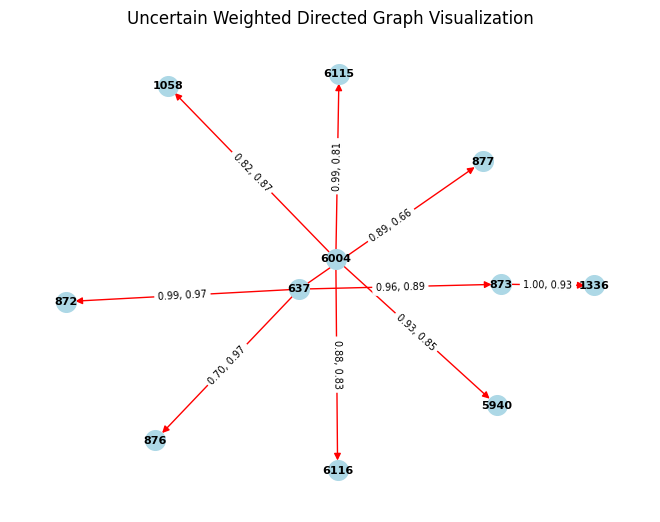

In [5]:
plot_graph_v2(ObsEmailEuCore01)